In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
years=[2015,2016,2017]
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(years)))

## Year: [2015, 2016, 2017]

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

### load observations

In [7]:
dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb'))

In [11]:
dictCTD=dict()
for i in years:
    dictCTD[i]=pickle.load(open(os.path.join(datadir,f'Casts_{str(i)}.p'),'rb'))

In [12]:
dfCTD0=pd.concat(dictCTD.values(), ignore_index=True)

In [13]:
dfCTD=pd.merge(left=dfSta,right=dfCTD0,how='right',
             left_on='Station',right_on='Station')
#right join means all rows in right table (dfCTD) are included in output
dfCTD.head()

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Date
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.160999,9.1318,23.311800,0.809025,7.303436,1.1961,-118.5,2015-01-20
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.159700,9.1321,23.310699,0.829323,7.307796,1.2157,-118.0,2015-01-20
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.154900,9.1334,23.306700,0.791626,7.327198,1.2351,-117.5,2015-01-20
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.152300,9.1341,23.304600,0.791626,7.315753,1.2018,-117.0,2015-01-20
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.154200,9.1330,23.306299,0.817724,7.321530,1.2093,-116.5,2015-01-20


In [14]:
# check that there are no stations without lat and lon:
dfCTD.loc[pd.isnull(dfCTD['Latitude'])]

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Date


In [15]:
# check one to one matches:
len(dfCTD),len(dfCTD0), len(dfSta)

(155398, 155398, 39)

In [16]:
# where no time is provided, set time to midday Pacific time = ~ 20:00 UTC for now
# the code below takes advantage of all elements in 'Date' having a time component 
# set to midnight
dfCTD['dtUTC']=[iiD+dt.timedelta(hours=20) for iiD in dfCTD['Date']]

In [17]:
# Column names must be altered
dfCTD.rename(columns={'Latitude':'Lat','Longitude':'Lon'},inplace=True)
dfCTD['Z']=-1*dfCTD['Z']
dfCTD.head()

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Salinity,Temperature,Sigma,Chl,DO,Turb,Z,Date,dtUTC
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.160999,9.1318,23.311800,0.809025,7.303436,1.1961,118.5,2015-01-20,2015-01-20 20:00:00
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.159700,9.1321,23.310699,0.829323,7.307796,1.2157,118.0,2015-01-20,2015-01-20 20:00:00
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.154900,9.1334,23.306700,0.791626,7.327198,1.2351,117.5,2015-01-20,2015-01-20 20:00:00
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.152300,9.1341,23.304600,0.791626,7.315753,1.2018,117.0,2015-01-20,2015-01-20 20:00:00
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,30.154200,9.1330,23.306299,0.817724,7.321530,1.2093,116.5,2015-01-20,2015-01-20 20:00:00


In [18]:
# Calculate Absolute (Reference) Salinity (g/kg) and Conservative Temperature (deg C) from 
# Salinity (psu) and Temperature (deg C):
press=gsw.p_from_z(-1*dfCTD['Z'],dfCTD['Lat'])
dfCTD['SA']=gsw.SA_from_SP(dfCTD['Salinity'],press,
                           dfCTD['Lon'],dfCTD['Lat'])
dfCTD['CT']=gsw.CT_from_t(dfCTD['SA'],dfCTD['Temperature'],press)

In [19]:
print(len(dfCTD),'data points')
print('Number of data points in each region:')
dfCTD.groupby('Basin')['SA'].count()

155398 data points
Number of data points in each region:


Basin
Admiralty Inlet           24560
Grays Harbor                338
Hood Canal Basin          20943
Main Basin                33077
South Basin               30809
Strait of Georgia         11300
Strait of Juan de Fuca    18091
Whidbey Basin             13281
Willapa Bay                2951
Name: SA, dtype: int64

### set up variables for model-data matching

In [21]:
# start_date and end_date are the first and last dates that will 
#  be included in the matched data set
start_date = dt.datetime(years[0],1,1)
end_date = dt.datetime(years[-1],12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'vosaline':'grid_T','votemper':'grid_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'ptrc_T':1,'grid_T':1}
# Note: to switch between 201812 and 201905 model results, change PATH
# to switch from hourly to daily model output, change fdict values from 1 to 24 (but daily 
#  files are not available for some runs and file types)

In [22]:
data=et.matchData(dfCTD,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 46.453155 -124.00960333333333  not matched to domain
(Lat,Lon)= 46.463155 -123.94126833333334  not matched to domain
(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.703986666666665 -123.837385  not matched to domain
(Lat,Lon)= 46.937313333333336 -123.91322333333333  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain
progress: 0.0%
progress: 3.3012670262846884%
progress: 6.602534052569377%
progress: 9.903801078854064%
progress: 13.205068105138754%
progress: 16.50633513142344%
progress: 19.80760215770813%
progress: 23.108869183992816%
progress: 26.410136210277507%
progress: 29.711403236562195%
progress: 33.01267026284688%
progress: 36.31393728913157%
progress: 39.61520431541626%
progress: 42.91647134170095%
progress: 46.2177383679856

In [23]:
cm1=cmocean.cm.thermal
with nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

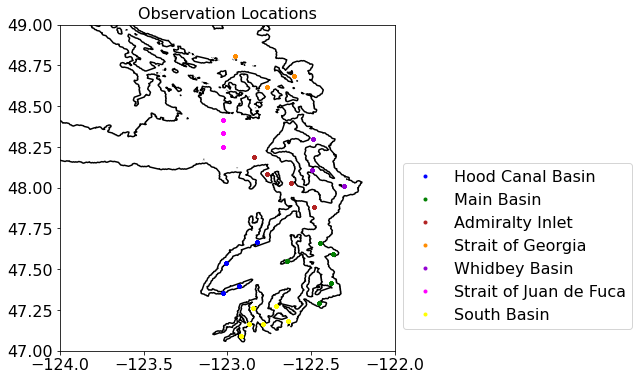

In [30]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'yellow','darkgoldenrod','mediumspringgreen','royalblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)

# When working with multiple years, a for loop is necessary to split things up by months. 
JFMd=dict()
Aprd=dict()
MJJAd=dict()
SONDd=dict()
for i in years:
    JFMd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,4,1)),:]
    Aprd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,5,1))&(data.dtUTC>dt.datetime(i,4,1)),:]
    MJJAd[i]=data.loc[iz&(data.dtUTC<=dt.datetime(i,9,1))&(data.dtUTC>dt.datetime(i,5,1)),:]
    SONDd[i]=data.loc[iz&(data.dtUTC>dt.datetime(i,9,1)),:]
JFM=pd.concat(JFMd.values(), ignore_index=True)
Apr=pd.concat(Aprd.values(), ignore_index=True)
MJJA=pd.concat(MJJAd.values(), ignore_index=True)
SOND=pd.concat(SONDd.values(), ignore_index=True)

In [91]:
# defning a dictionary that brakes the data down by individual stations.
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datyear=dict()
for ind, iyear in enumerate(data.dtUTC.dt.year.unique()):
    datyear[iyear] = data.loc[data.dtUTC.dt.year==iyear]

datyearreg=dict()
for iyear in datyear:
    datyearreg[iyear]=dict()
    for iregion in datyear[iyear].Basin.unique():
        datyearreg[iyear][iregion]=datyear[iyear].loc[datyear[iyear].Basin==iregion]



In [103]:
def byDepth(ax,obsvar,modvar,lims,byyear = False,year = 'NA'):
    if byyear == False:
        ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    elif byyear == True:
        ps=et.varvarPlot(ax,datyear[year],obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
        l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims,year):
    ps=[]
    for ind, iregion in enumerate(data[data.dtUTC.dt.year==2016].Basin.unique()):
        ax.plot(datyearreg[year][iregion]['Lon'], datyearreg[year][iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datyearreg[year][iregion],obsvar,modvar,
                        cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byStation(ax,obsvar,modvar,lims,region):
    ps=[]
    for ind, istation in enumerate(data[data['Basin'] == region].Station.unique()):
        ax.plot(datstat[istation]['Lon'], datstat[istation]['Lat'],'.',
                    color = colors[ind], label=istation)
        ps0=et.varvarPlot(ax,datstat[istation],obsvar,modvar,
                            cols=(colors[ind],),lname=istation)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [33]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Hood Canal Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'Strait of Juan de Fuca', 'South Basin'])

## Model vs observed Salinity for 2015-2017

In [109]:
def multi_depreg_graph(down,figsize,figrange,years,obsvar,modvar,phyvar_name):
    fig,ax=plt.subplots(down,2,figsize=figsize)
    for d,Y in zip(range(down),years):
        ps,l=byDepth(ax[d][0],obsvar,modvar,figrange,byyear=True,year=Y)
        ax[d][0].set_title(f'{phyvar_name} (g kg$^-1$) By Depth for {Y}')
        ps,l=byRegion(ax[d][1],obsvar,modvar,figrange,year=Y)
        ax[d][1].set_title(f'{phyvar_name} (g kg$^-1$) By Region for {Y}');

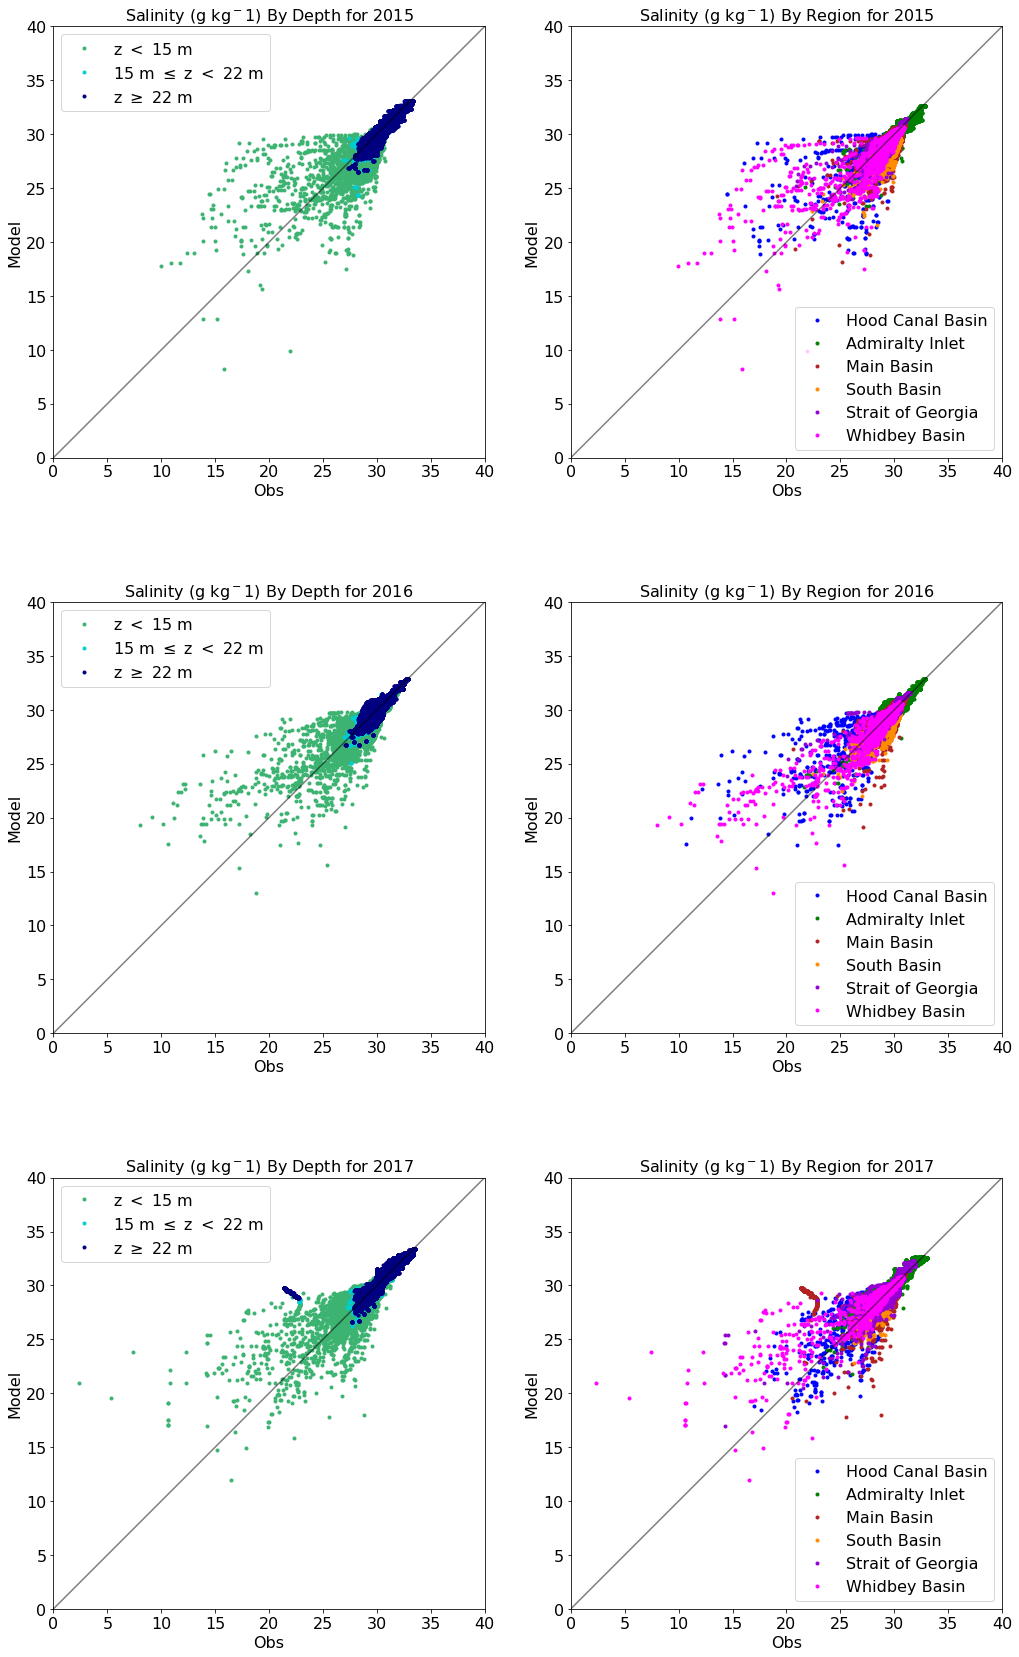

In [104]:
obsvar='SA'
modvar='mod_vosaline'

multi_depreg_graph(3,(17,30),(0,40),years,obsvar,modvar,'Salinity')

## Model vs Observed Temperature for 2015-2017

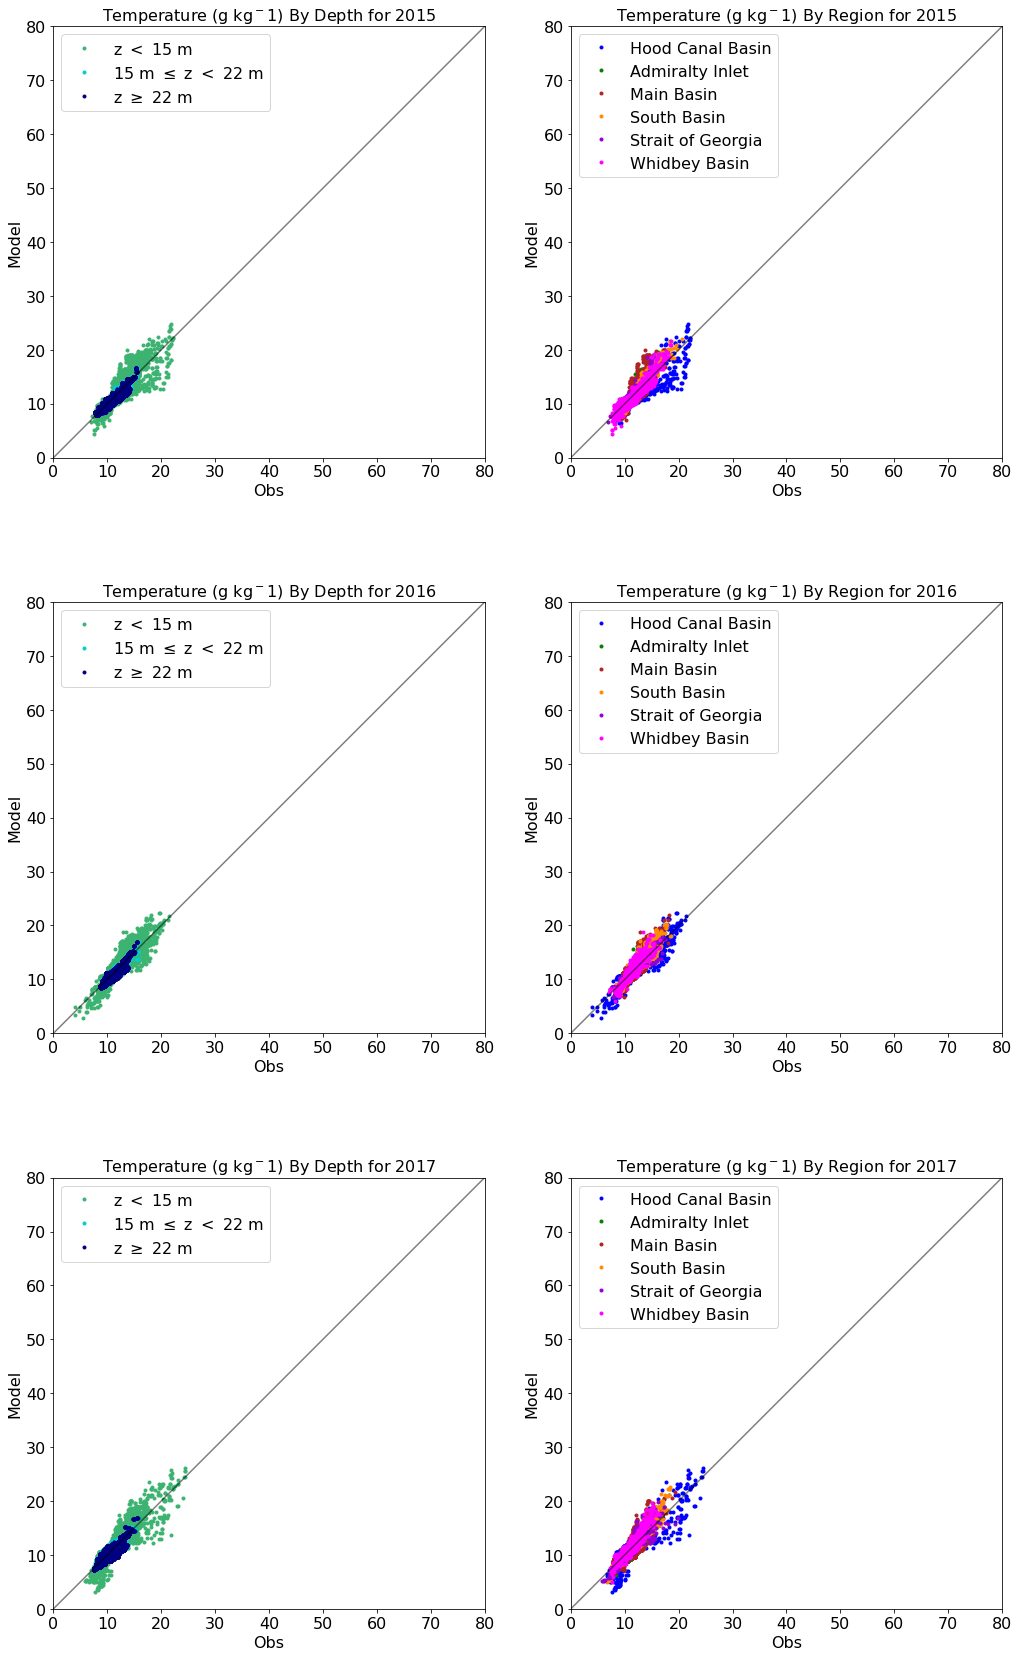

In [108]:
obsvar='CT'
modvar='mod_votemper'

multi_depreg_graph(3,(17,30),(0,80),years,obsvar,modvar,'Temperature')